# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.


#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}
    
    # perform 5 fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=100)
    for b in parameters:
        X_train_scaled_list, X_val_scaled_list, y_train_list, y_val_list = [], [], [], []

        for train_index, val_index in kf.split(X_train):
            # split training and validation set
            X_train_fold, X_val_fold, y_train_fold, y_val_fold = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
            scaler = preprocessing.StandardScaler()
            
            # do scaling independently on each cross validation set
            X_train_scaled_fold = scaler.fit_transform(X_train_fold)
            X_val_scaled_fold = scaler.transform(X_val_fold)
            
            # add to the list
            X_train_scaled_list.append(X_train_scaled_fold)
            X_val_scaled_list.append(X_val_scaled_fold)
            y_train_list.append(y_train_fold)
            y_val_list.append(y_val_fold)
        
        # add to the dict
        X_train_scaled_dict[b] = X_train_scaled_list
        X_val_scaled_dict[b] = X_val_scaled_list
        y_train_dict[b] = y_train_list
        y_val_dict[b] = y_val_list

            
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

from common_utils import split_dataset
# load data
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
columns_to_drop = ['filename', 'label']

# perform data splitting first
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop=columns_to_drop, test_size=0.25, random_state=100)

# do 5-fold split
batch_sizes = [64, 128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:
# YOUR CODE HERE
from common_utils import EarlyStopper

# training function
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # inform Dropout layer to work
    for X, y in dataloader:
        # forward pass and compute loss
        pred = model(X).reshape(-1)
        loss = loss_fn(pred, y.float())

        # back-prop and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# validation function
def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    val_loss, correct = 0, 0
    model.eval()  # inform no dropout during validation

    with torch.no_grad():
        for X, y in dataloader:
            # forward pass
            pred = model(X).reshape(-1)
            val_loss += loss_fn(pred, y.float()).item() * X.size(0)
            
            correct += ((pred > 0.5).long() == y).type(torch.float).sum().item()

    val_loss /= size
    val_acc = correct / size
    return val_loss, val_acc

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, para_name='batch_size'):
    no_features = 77 # feature number
    no_hidden = 128  # neuron number of hidden layers
    no_labels = 1  # output label number
    lr = 0.001  # learning rate

    accuracies = {}
    last_epoch_times = {}

    for b in batch_sizes:
        accuracy = []
        last_epoch_time = []
        print(f"batch size: {b}")

        for i in range(5):
            no_epochs = 100  # set epoch number

            # initialize model
            model = MLP(no_features, no_hidden, no_labels)

            # set Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # set DataLoader
            train_dataset = CustomDataset(X_train_scaled_dict[b][i], y_train_dict[b][i])
            val_dataset = CustomDataset(X_val_scaled_dict[b][i], y_val_dict[b][i])
            train_dataloader = DataLoader(train_dataset, batch_size=b, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=b, shuffle=True)

            # initialize early stopper
            early_stopper = EarlyStopper(patience=3, min_delta=0)

            # start training
            for epoch in range(no_epochs):
                start_time = time.time()

                train_loop(train_dataloader, model, loss_fn, optimizer)
        
                val_loss, val_acc = val_loop(val_dataloader, model, loss_fn)

                end_time = time.time()

                # early stop setting
                if early_stopper.early_stop(val_loss): 
                    print(f"Early stopping at epoch {epoch + 1}!")
                    break
            
            # update accuracy and time
            accuracy.append(val_acc)
            last_epoch_time.append(end_time - start_time)
            print(f"experiment {i + 1}: accuracy: {val_acc:>4f}; last epoch time {end_time - start_time:>4f}")

        accuracies[b] = accuracy 
        last_epoch_times[b] = last_epoch_time
        print(f"batch size {b}: mean accuracy: {sum(accuracies[b]) / 5:>4f}; mean last epoch time {sum(last_epoch_times[b]) / 5:>4f}")

    return accuracies, last_epoch_times


batch_sizes = [64, 128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


batch size: 64


D:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Early stopping at epoch 24!
experiment 1: accuracy: 0.736871; last epoch time 0.617354
Early stopping at epoch 14!
experiment 2: accuracy: 0.712548; last epoch time 0.604116
Early stopping at epoch 26!
experiment 3: accuracy: 0.740597; last epoch time 0.570712
Early stopping at epoch 20!
experiment 4: accuracy: 0.710730; last epoch time 0.719841
Early stopping at epoch 29!
experiment 5: accuracy: 0.755531; last epoch time 0.659094
batch size 64: mean accuracy: 0.731256; mean last epoch time 0.634224
batch size: 128
Early stopping at epoch 26!
experiment 1: accuracy: 0.739635; last epoch time 0.389210
Early stopping at epoch 25!
experiment 2: accuracy: 0.746269; last epoch time 0.366104
Early stopping at epoch 25!
experiment 3: accuracy: 0.726217; last epoch time 0.380426
Early stopping at epoch 20!
experiment 4: accuracy: 0.721792; last epoch time 0.399664
Early stopping at epoch 33!
experiment 5: accuracy: 0.768252; last epoch time 0.362040
batch size 128: mean accuracy: 0.740433; mea

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

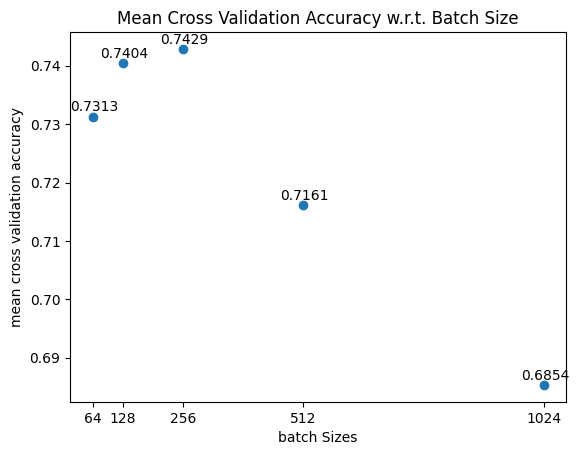

In [5]:
# YOUR CODE HERE
# plot accuracies
batch_sizes_list = list(cross_validation_accuracies.keys())
mean_accuracies = [sum(cross_validation_accuracies[batch_size]) / len(cross_validation_accuracies[batch_size]) for batch_size in batch_sizes_list]
mean_last_epoch_times = [sum(cross_validation_times[batch_size]) / len(cross_validation_times[batch_size]) for batch_size in batch_sizes_list]
plt.xlabel('batch Sizes')
plt.xticks(batch_sizes_list)
plt.ylabel('mean cross validation accuracy')
plt.title('Mean Cross Validation Accuracy w.r.t. Batch Size')
plt.scatter(batch_sizes_list, mean_accuracies)

for i, txt in enumerate(zip(batch_sizes_list, mean_accuracies)):
    plt.annotate(f'{txt[1]:.4f}', (batch_sizes_list[i], mean_accuracies[i]), textcoords="offset points", xytext=(1, 4), ha='center')

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:


df = pd.DataFrame({'Batch Size': batch_sizes_list,
                   'Last Epoch Time': mean_last_epoch_times
                  })

df

,Batch Size,Last Epoch Time
0,64,0.634224
1,128,0.379489
2,256,0.281504
3,512,0.256422
4,1024,0.567736


In [7]:
# YOUR CODE HERE
optimal_batch_size = 256
reason = "We choose 256 to be the optimal batch size is because it has the highest mean cross validation accuracy on the validation set across all batcch sizes."\
         "Also, the mean last epoch time is relatively small comparing to other batch sizes, which leads to a relatively short training time and high efficiency."\
         "Therefore, it offers the best trade-off between the performance and training speed."